# The All-Knowing Cube of Probability

> This example uses array computations to explore the concept of conjugate distributions.
It is an extension of *[Think Bayes](https://greenteapress.com/wp/think-bayes/)*, [Chapter 18](https://allendowney.github.io/ThinkBayes2/chap18.html), which explains how to use conjugate priors to do Bayesian updates with very little computation. 

The all-knowing cube of probability is an 3-D array that contains the past, the present, and the probabilistic future.

At first, the cube appears to be a collection of binomial PMFs, but if we turn it sideways, we see that it is also a collection of negative binomial PMFs, and if we turn it sideways again, it is also a collection of grid-approximated beta distributions.

This tripartite nature is the source of its uncanny ability to perform Bayesian updates, which I will demonstrate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Making the cube

Suppose you run $n$ trials where the probability of success is $p$.
To compute the probability of $k$ successes, we can use the binomial distribution.

For example, here's a range of values for $k$ and $n$, and a discrete grid of values for $p$.

In [2]:
ks = np.arange(101)
ns = np.arange(101)
ps = np.linspace(0, 1, 101)

We can use `meshgrid` to make a 3-D grid of $k$, $n$, and $p$, and `binom` to evaluate the binomial PMF at each point.

In [3]:
from scipy.stats import binom

K, N, P = np.meshgrid(ks, ns, ps, indexing='ij')
cube = binom.pmf(K, N, P)
cube.shape

(101, 101, 101)

The result is the **all-knowing cube of probability**, so-called because it can answer all of our questions about Bernoulli trials.
Allow me to demonstrate.

## The binomial distribution

Suppose we are given $n$ and $p$, and we would like to know the distribution of $k$.
We can answer that question by selecting a vector from the cube along the $k$ axis.

In [4]:
n = 50
p = 50
pmf_k = cube[:, n, p]

The result is a normalized PMF.

In [5]:
pmf_k.sum()

0.9999999999999996

Here's what it looks like.

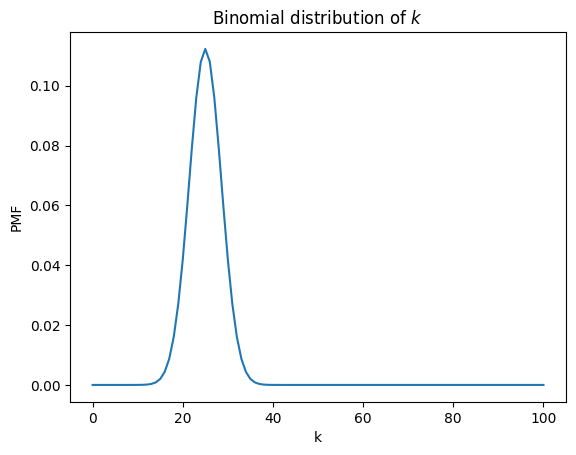

In [6]:
plt.plot(ks, pmf_k)
plt.xlabel('k')
plt.ylabel('PMF')
plt.title('Binomial distribution of $k$');

Because we used `binom` to compute the cube, we should not be surprised to find that this slice from the cube is a binomial PMF.
But just to make sure, we can use `binom` again to confirm it.

In [7]:
pmf_binom = binom.pmf(ks, n, p/100)

And we can check that the results are consistent.

In [8]:
np.allclose(pmf_k, pmf_binom)

True

So we can think of the cube as a collection of binomial PMFs.
But we can also think of it as a joint distribution of $k$, $n$, and $p$, which raises the question: what do we get if we select a vector along the $n$ and $p$ axes?

## The negative binomial distribution

Suppose we plan to run Bernoulli trials with probability $p$ until we see $k$ successes.
How many trials will it take?

We can answer this question by selecting a vector from the cube along the $n$ axis.

In [9]:
k = 25
p = 50
pmf_n = cube[k, :, p].copy()

The result is close to the answer we want, but there's something we have to fix.
Remember that the values in the cube come from the binomial PMF, which looks like this.

$$Pr(k; n, p) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

The first term is the binomial coefficient, which indicates that there are $n$ places we could find $k$ successes.
But if we keep running trials until we see $k$ successes, we know the last trial will be a success, which means there are only $n-1$ places we could find the other $k-1$ successes.

So we have to adjust the values from the cube by dividing the elements by $n/k$.

In [10]:
np.seterr(divide='ignore', invalid='ignore')

pmf_n /= (ns / k)
pmf_n[0] = 0

And normalize the results to get a proper PMF.

In [11]:
pmf_n /= pmf_n.sum()

Here's what it looks like.

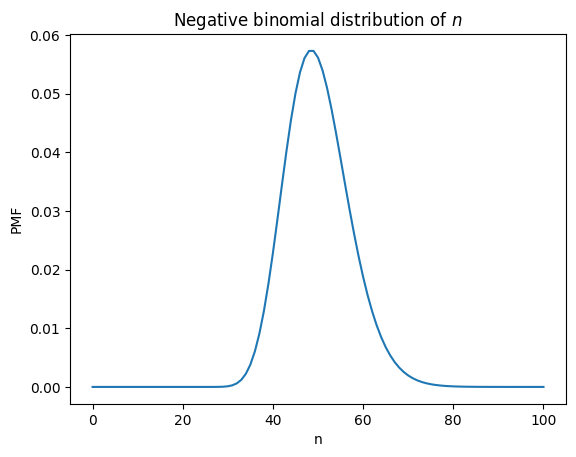

In [12]:
plt.plot(ns, pmf_n)
plt.xlabel('n')
plt.ylabel('PMF')
plt.title('Negative binomial distribution of $n$');

This is a negative binomial distribution, which we can confirm using `scipy.stats.nbinom`.

In [13]:
from scipy.stats import nbinom

pmf_nbinom = nbinom.pmf(ns-k, k, p/100)
pmf_nbinom.sum()

0.9999999094998685

In [14]:
np.allclose(pmf_n, pmf_nbinom)

True

To see why this works we can compare the binomial PMF, which is a distribution over $k$ with $n$ and $p$ as parameters:

$$Pr(k; n, p) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

And the negative binomial PMF, which I've written as a distribution over $n$ with $k$ and $p$ as parameters:

$$Pr(n; k, p) = \binom{n-1}{k-1} p^k (1-p)^{n-k}$$

This is not the most common way to parameterize the negative binomial distribution, but it shows that the only difference is in the binomial coefficient, because we know that the last trial is a success.

## The beta distribution

Suppose we have 101 devices that perform Bernoulli trials with different probabilities.
The first device has $p=0$, the second has $p=0.01$, and so on up to the last device with $p=1$.

Now suppose we choose one of the devices so that all values of $p$ are equally likely.
If we run $n$ trials and see $k$ successes, what is the distribution of $p$?

We can answer this question by selecting a vector from the cube along the $p$ axis.

In [15]:
k = 25
n = 50

pdf_p = cube[k, n, :].copy()

The result is not normalized.

In [16]:
pdf_p.sum()

1.96078431372549

But we can normalize it like this.

In [17]:
pdf_p /= pdf_p.sum()

And here's what it looks like.

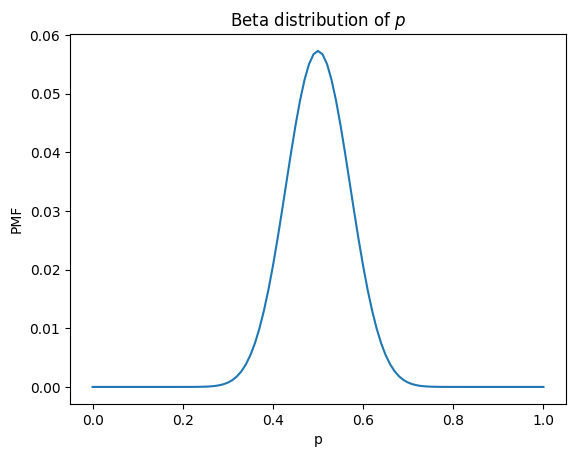

In [18]:
plt.plot(ps, pdf_p)
plt.xlabel('p')
plt.ylabel('PMF')
plt.title('Beta distribution of $p$');

This is a beta distribution, which we can confirm by running `scipy.stats.beta` with a change of variables, $a = k+1$ and $b = n-k+1$.

In [19]:
from scipy.stats import beta

a = k + 1
b = n - k + 1
a, b

(26, 26)

In [20]:
pdf_beta = beta.pdf(ps, a, b)
pdf_beta /= pdf_beta.sum()

In [21]:
np.allclose(pdf_p, pdf_beta)

True

To see why this works, let's compare the PDF of the beta distribution

$$f(p, a, b) = \frac{1}{B(a, b)} p^{a-1} (1-p)^{b-1} $$

And the PMF of the binomial distribution.

$$Pr(k; n, p) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

With the change of variables, they are identical except for the first term, which normalizes the distributions.

## Conjugate priors

This similarity is the reason the beta and binomial are conjugate distributions, which means they are joined together.
This relationship has a useful property for Bayesian statistics: if the prior distribution of $p$ is beta and the likelihood of the data is binomial, the posterior distribution is also beta.

To see how that works, here is the PDF of the a beta prior distribution with parameters $a$ and $b$.

$$p^{a-1} (1-p)^{b-1}$$

I have omitted the normalizing factor -- we don't need it because we are going to normalize the distribution after the update.

Now suppose we see $k$ successes in $n$ trials.
The likelihood of this data is given by the binomial distribution, which has this PMF.

$$p^{k} (1-p)^{n-k}$$

Again, I have omitted the normalizing factor.
Now to get the unnormalized posterior, we multiply the beta prior and the binomial likelihood. The result is

$$p^{a-1+k} (1-p)^{b-1+n-k}$$

which we recognize as an unnormalized beta distribution with parameters $a+k$ and $b+n-k$.

So if we observe $k$ successes in $n$ trials, we can do the update by making a beta posterior with parameters $a+k$ and $b+n-k$.

As an example, suppose the prior is a beta distribution with parameters $a=2$ and $b=3$.

In [22]:
a = 2
b = 3

prior = beta.pdf(ps, a, b)

And suppose we see $k=5$ successes in $n=10$ attempts.

In [23]:
k = 5
n = 10

like = binom.pmf(k, n, ps)

We can compute the posterior by multiplying the prior and the likelihood, then normalizing the results.

In [24]:
posterior = prior * like
posterior /= posterior.sum()

Or we can compute a beta distribution with the updated parameters.

In [25]:
posterior_beta = beta.pdf(ps, a+k, b+n-k)
posterior_beta /= posterior_beta.sum()

The result is the same either way.

In [26]:
np.allclose(posterior, posterior_beta)

True

But we don't have to compute the posterior by doing an explicit update, or by computing a beta distribution, because the all-knowing cube of probability already knows the answer -- we just have to ask.

The following function takes the parameters $a$ and $b$ and looks up the corresponding beta distribution already computed in the cube.

In [27]:
def get_beta(a, b, cube):
    k = a - 1
    n = b + k - 1

    pdf = cube[k, n, :].copy()
    pdf /= pdf.sum()
    return pdf

We can use it to get the posterior distribution of $p$ from the cube.

In [28]:
posterior_cube = get_beta(a + k, b + n - k, cube)

And confirm that we get the same result.

In [29]:
np.allclose(posterior_beta, posterior_cube)

True

Here's what it looks like.

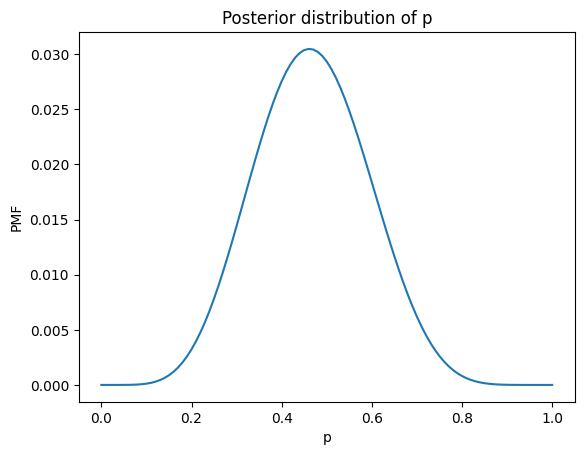

In [30]:
plt.plot(ps, posterior_cube)

plt.xlabel('p')
plt.ylabel('PMF')
plt.title('Posterior distribution of p');

## Update with nbinom


Now suppose that instead of running $n$ trials, we keep running trials until we see $k$ successes -- and suppose it takes $n$ trials.

In this case, we can use the negative binomial distribution to compute the likelihood of the data.

In [31]:
like2 = nbinom.pmf(n-k, k, ps)
like2[0] = 0

And we can do the update in the usual way.

In [32]:
posterior2 = prior * like2
posterior2 /= posterior2.sum()

It turns out that the result is the same in both cases:

* If we decide ahead of time to run $n$ trials, and see $k$ successes, or

* If we run until we see $k$ successes, and it takes $n$ trials.

In [33]:
np.allclose(posterior, posterior2)

True

Bayesian inference only depends on the data, not the stopping condition.
Or, as my friend Ted Bunn put it: [Who knows what evil lurks in the hearts of men? The Bayesian doesn't care.](https://blog.richmond.edu/physicsbunn/2012/01/05/who-knows-what-evil-lurks-in-the-hearts-of-men-the-bayesian-doesnt-care/)

## Posterior predictive distributions

The all-knowing cube of probability knows what we should believe in the light of new data, but that's not all.
It also knows the future, at least probabilistically.

After an update, we can get posterior predictive distribution by computing a weighted mixture of binomial distributions with different values of $p$, weighted by the posterior probabilities.

We can do that by selecting the $(k, p)$ plane from the cube, multiplying by the posterior and summing away the $p$ axis.

In [34]:
post_pred_k = (cube[:, n, :] * posterior).sum(axis=1)

The result is a distribution over $k$. Here's what it looks like (dropping values of $k$ greater than $n$).

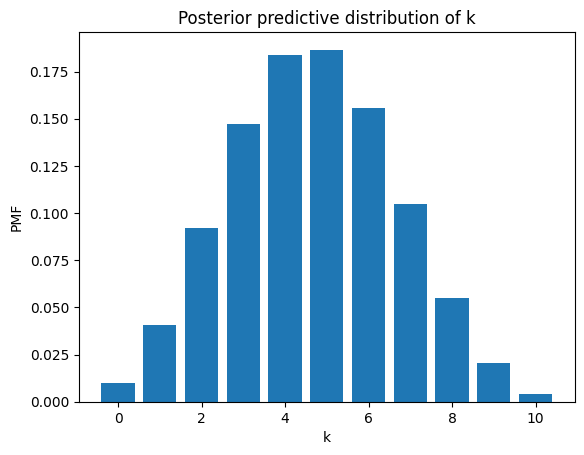

In [35]:
plt.bar(ks[:n+1], post_pred_k[:n+1])

plt.xlabel('k')
plt.ylabel('PMF')
plt.title('Posterior predictive distribution of k');

A beta mixture of binomials is a beta-binomial distribution, and it has a PMF we can compute analytically.

In [36]:
from scipy.stats import betabinom

post_pred_bb = betabinom.pmf(ks, n, a+k, b+n-k)

So we can confirm that the all-knowing cube was correct.

In [37]:
np.allclose(post_pred_k, post_pred_bb)

True

## The other posterior predictive

We can also use the cube to compute the posterior predictive distribution of $n$ given a required number of successes, $k$.

We start by selecting the $(n, p)$ plane from the cube, which is a collection of negative binomials distributions, except that we have to correct them by dividing through by $n/k$, as we did above.

Actually, we only have to divide by $n$ because $k$ is a constant that will get normalized away.

In [38]:
plane = cube[k, :, :] / ns[:, None]
plane[0] = 0

Now we can compute a weighted sum as in the previous example, multiplying by the posterior and summing away the $p$ axis.

In [39]:
post_pred_n = (plane * posterior).sum(axis=1)
post_pred_n /= post_pred_n.sum()

Here's what it looks like.

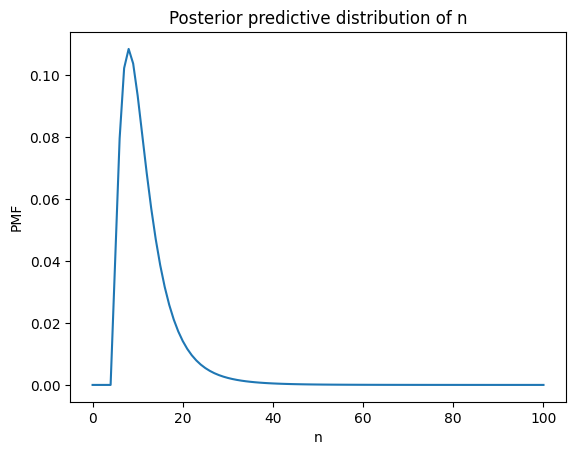

In [40]:
plt.plot(ns, post_pred_n)

plt.xlabel('n')
plt.ylabel('PMF')
plt.title('Posterior predictive distribution of n');

A beta-weighted mixture of negative binomials is a beta-negative binomial distribution, and it has a PMF we can compute analytically.
SciPy doesn't have a function to do it, but we can write our own using functions in `scipy.special`.

In [41]:
import scipy.special as sps

def betanegbinom_pmf(n, r, a, b):
    """Compute the PMF of the beta-negative binomial distribution.
    
    Generated by ChatGPT, revised based on
    https://en.wikipedia.org/wiki/Beta_negative_binomial_distribution

    Parameters:
    - n: Number of trials before stopping.
    - r: Number of successes required.
    - a: Shape parameter of the beta distribution.
    - b: Shape parameter of the beta distribution.

    Returns:
    - PMF value for the given parameters.
    """
    k = n - r
    binomial_coefficient = sps.comb(r + k - 1, k)
    beta_num = sps.beta(a + r, b + k)
    beta_den = sps.beta(a, b)

    pmf = binomial_coefficient * (beta_num / beta_den)
    return pmf

The conventional parameterization of the beta-negative binomial uses $k$ for the number of failures and $r$ for the number of required successes, so we have to change some variables to get a distribution over $n$. 

In [42]:
post_pred_bnb = betanegbinom_pmf(ns, k, a+k, b+n-k)
post_pred_bnb /= post_pred_bnb.sum()

But we can confirm that the result from the cube is consistent with the analytic PMF.

In [43]:
np.allclose(post_pred_n, post_pred_bnb)

True

In conclusion, the all-knowing cube of probability contains the past (the prior distributions), the present (the posterior distributions), and the future (the posterior predictive distributions).

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)